In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("./stations_cleaned_sample.csv")
originalColumns = df.columns.tolist()
df.shape

(1611, 21)

In [3]:
df.sample(10)

,station_code,monitoring_location,state_name,temp_min,temp_max,do_min,do_max,ph_min,ph_max,conductivity_min,...,bod_min,bod_max,nitrate_min,nitrate_max,fecal_coliform_min,fecal_coliform_max,total_coliform_min,total_coliform_max,fecal_streptococci_min,fecal_streptococci_max
1353,4253,"RIVER MUSI AT BAPUGHAT SANGAM, HYDERABAD",TELANGANA,25.0,29.0,0.3,3.0,6.8,7.9,384.0,...,2.2,14.0,2.08,8.20,4.0,350.0,280.0,920.0,2.0,6.0
20,1008,RIVER BEAS AT D/S DEHRAGOPIPUR,HIMACHAL PRADESH,15.0,22.0,6.7,9.2,7.2,8.2,107.0,...,1.0,1.0,1.08,3.27,2.0,110.0,40.0,5400.0,2.0,2.0
264,1073,"RIVER GANGA AT TARIGHAT (GHAZIPUR), U.P",UTTAR PRADESH,23.0,31.5,6.5,8.2,7.7,8.0,336.0,...,3.5,4.7,0.78,2.32,9400.0,17000.0,15000.0,26000.0,6300.0,13000.0
845,4307,RIVER WAHREW AT MAJAI MEGHALAYA,NaN,17.0,19.0,7.6,8.5,6.9,7.3,33.0,...,1.0,1.4,0.32,5.51,2.0,2.0,27.0,79.0,2.0,2.0
1593,4744,RIVER SUBARNAREKHA BEFORE MEETING KHARKAI RIVER,JHARKHAND,15.1,36.0,6.6,8.8,7.0,7.8,228.0,...,1.3,3.3,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
240,10154,RIVER GANGA AT BATHING GHAT (BHARAOGHAT),UTTAR PRADESH,14.0,31.0,6.1,10.8,7.8,8.5,226.0,...,3.0,4.3,0.00,0.00,2100.0,4900.0,3100.0,7900.0,2.0,78.0
804,3715,"RIVER TUIRIAL MID STREAM, AIRFIELD, U/S OF TUI...",AIZAWL DIST. MIZORAM,19.0,24.0,4.2,8.1,7.4,8.4,143.0,...,1.0,1.4,0.02,5.32,NaN,NaN,NaN,NaN,NaN,NaN
1479,3579,RIVER CAUVERY AT WATER SUPPLY INTAKE POINT AT ...,KARNATAKA,23.0,33.0,5.2,6.8,7.9,8.7,205.0,...,2.0,4.0,1.00,3.40,78.0,260.0,940.0,1700.0,NaN,NaN
408,1358,RIVER HINDON AT GHAZIABAD D/S KULESHRA GB NAGA...,UTTAR PRADESH,20.0,25.0,0.3,8.8,6.4,8.4,304.0,...,3.2,48.0,0.75,0.96,2100.0,340000.0,3800.0,470000.0,1100.0,1100.0
660,4739,"RIVER KATRI RIVER, NEAR BHATINDA FALL, AT- TET...",JHARKHAND,18.0,34.0,5.2,7.5,7.3,7.6,1.2,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

In [5]:
df.columns

Index(['station_code', 'monitoring_location', 'state_name', 'temp_min',
       'temp_max', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min',
       'conductivity_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max',
       'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min',
       'total_coliform_max', 'fecal_streptococci_min',
       'fecal_streptococci_max'],
      dtype='object')

In [6]:
turb_cols = [c for c in df.columns if "turbid" in c or c.endswith("ntu") or c == "turbidity"]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.isna().sum()

station_code                0
monitoring_location         6
state_name                124
temp_min                    7
temp_max                    8
do_min                      8
do_max                      8
ph_min                      8
ph_max                      8
conductivity_min            8
conductivity_max            8
bod_min                     8
bod_max                     8
nitrate_min                56
nitrate_max                56
fecal_coliform_min        184
fecal_coliform_max        185
total_coliform_min        224
total_coliform_max        224
fecal_streptococci_min    766
fecal_streptococci_max    767
dtype: int64

In [9]:
summary = {
    "rows": len(df),
    "cols": len(df.columns),
    "original_columns": originalColumns,
    "normalized_columns": df.columns.tolist(),
    "candidate_turbidity_columns": turb_cols,
    "numeric_columns_count": len(numeric_cols)
}

In [10]:
schema_report = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "non_null": [df[c].notna().sum() for c in df.columns],
    "nulls": [df[c].isna().sum() for c in df.columns],
    "unique": [df[c].nunique(dropna=True) for c in df.columns]
})
schema_report

,column,dtype,non_null,nulls,unique
0,station_code,int64,1605,0,1604
1,monitoring_location,object,1599,6,1598
2,state_name,object,1481,124,116
3,temp_min,float64,1598,7,149
4,temp_max,float64,1597,8,164
5,do_min,float64,1597,8,101
6,do_max,float64,1597,8,115
7,ph_min,float64,1597,8,77
8,ph_max,float64,1597,8,78
9,conductivity_min,float64,1597,8,569


In [11]:
df[pd.isna(df['temp_max'])]

,station_code,monitoring_location,state_name,temp_min,temp_max,do_min,do_max,ph_min,ph_max,conductivity_min,...,bod_min,bod_max,nitrate_min,nitrate_max,fecal_coliform_min,fecal_coliform_max,total_coliform_min,total_coliform_max,fecal_streptococci_min,fecal_streptococci_max
0,1986,mg/L mg/L Ml 100 mL,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
796,4121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798,3736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,4118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
806,3717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807,2052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,1631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1592,4743,RIVER SUBARNAREKHA U/S HCL GHATSHILA,E.S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df = df[pd.notna(df['temp_max'])]

In [13]:
df.isna().sum()

station_code                0
monitoring_location         0
state_name                117
temp_min                    0
temp_max                    0
do_min                      0
do_max                      0
ph_min                      0
ph_max                      0
conductivity_min            0
conductivity_max            0
bod_min                     0
bod_max                     0
nitrate_min                48
nitrate_max                48
fecal_coliform_min        176
fecal_coliform_max        177
total_coliform_min        216
total_coliform_max        216
fecal_streptococci_min    758
fecal_streptococci_max    759
dtype: int64

In [14]:
missing = df[pd.isna(df['fecal_coliform_min'])]

In [15]:
for c in ['nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']:
    df[c+"missing"] = df[c].isna().astype(int)
    df[c] = df[c].fillna(df[c].median())

In [16]:
df.drop(columns=["fecal_streptococci_min","fecal_streptococci_max"], inplace=True)

In [17]:
df["state_name"] = df["state_name"].fillna("Unknown")

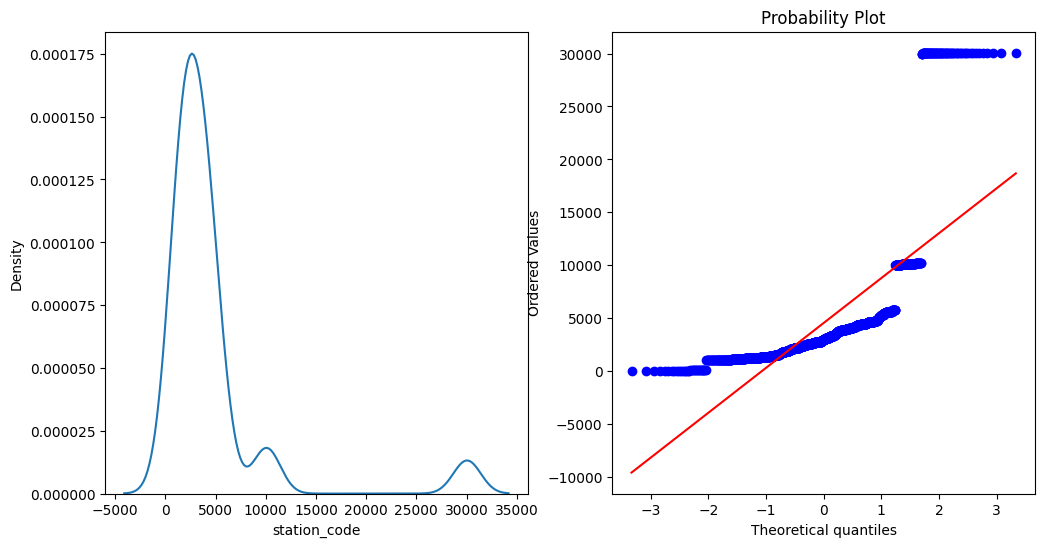

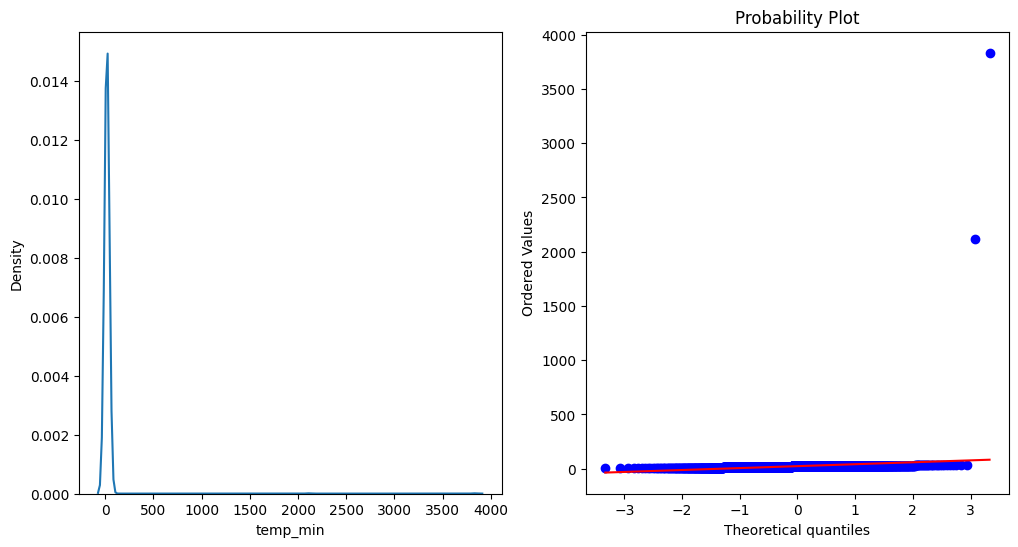

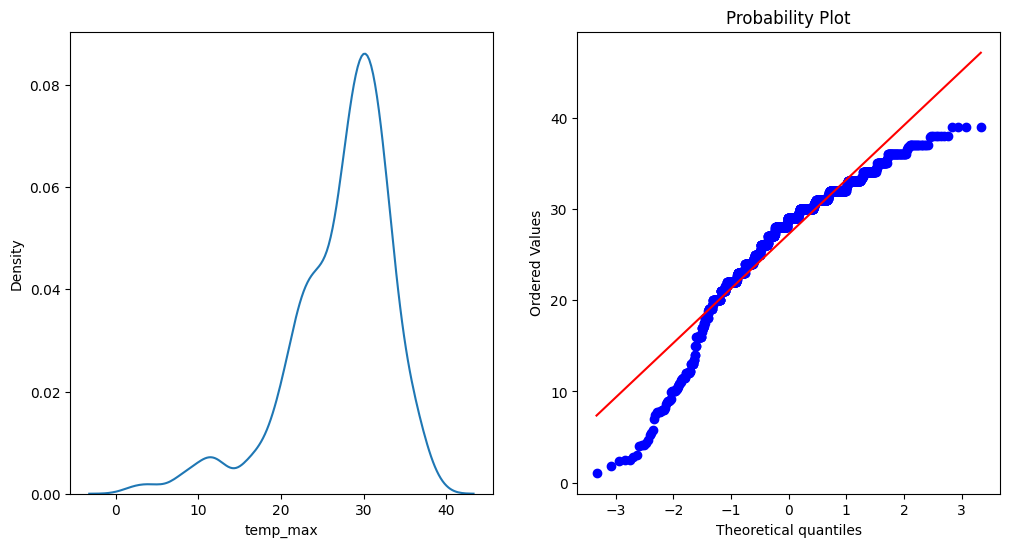

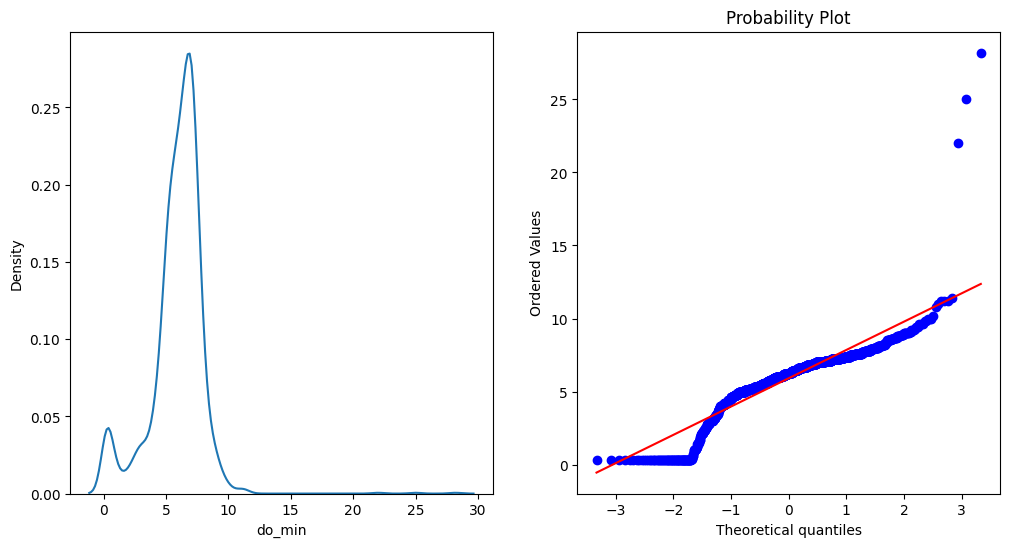

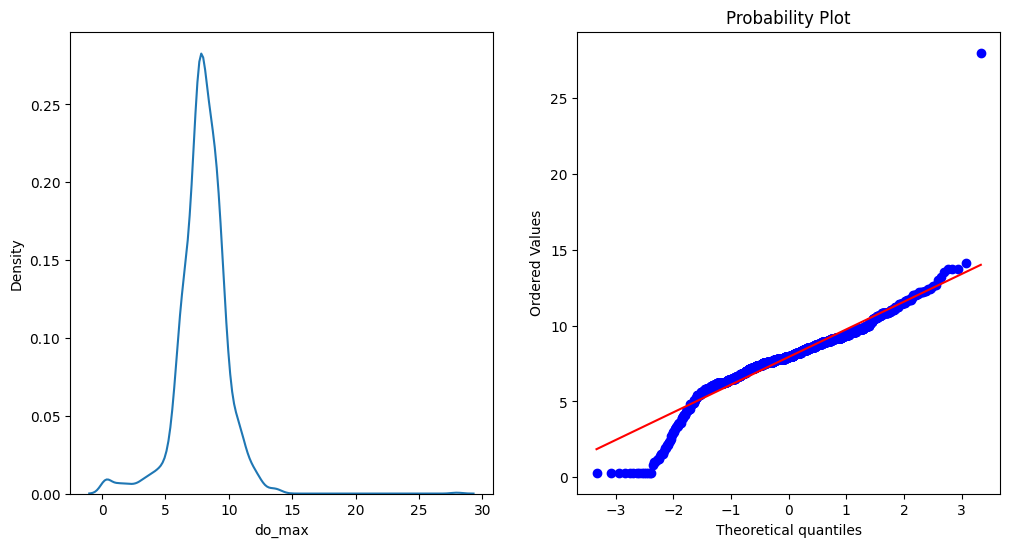

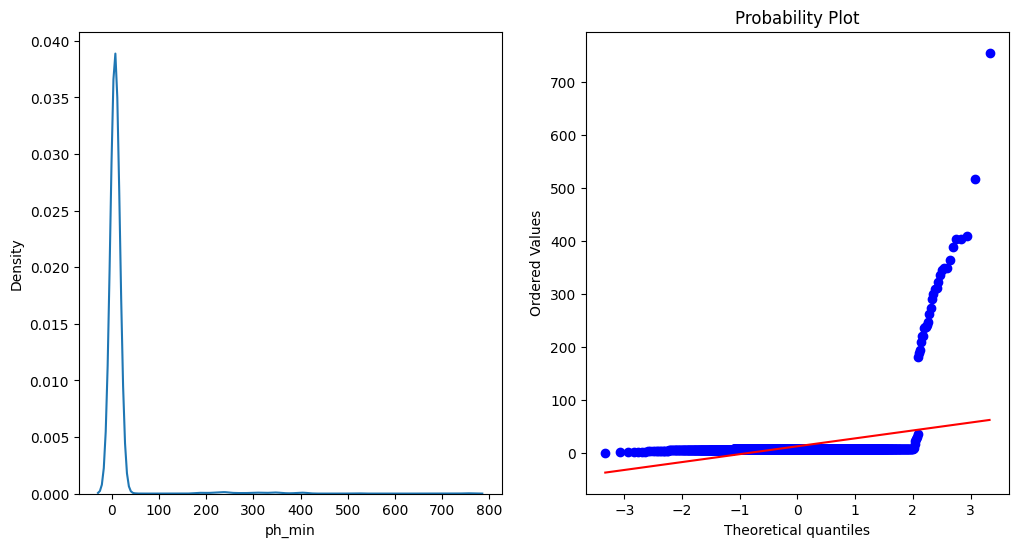

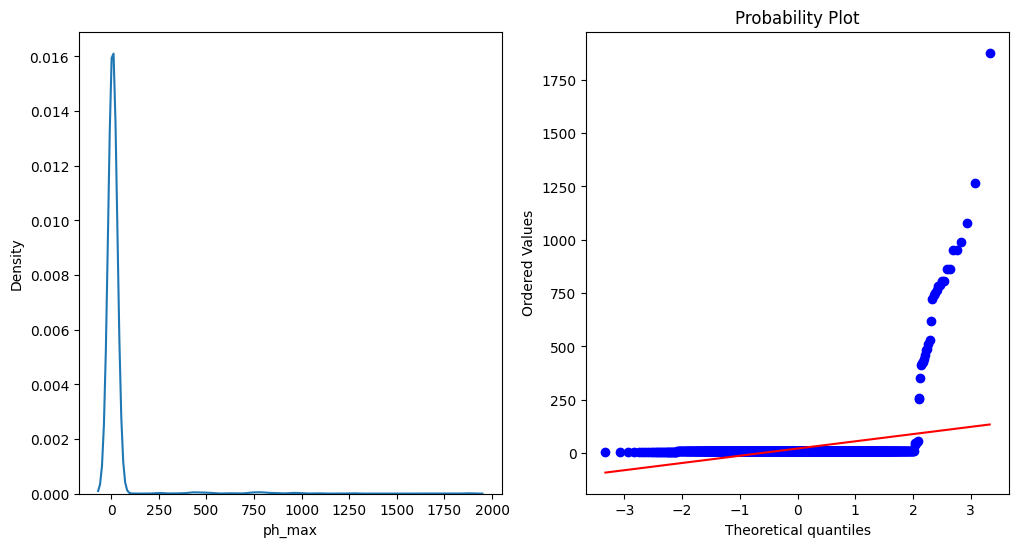

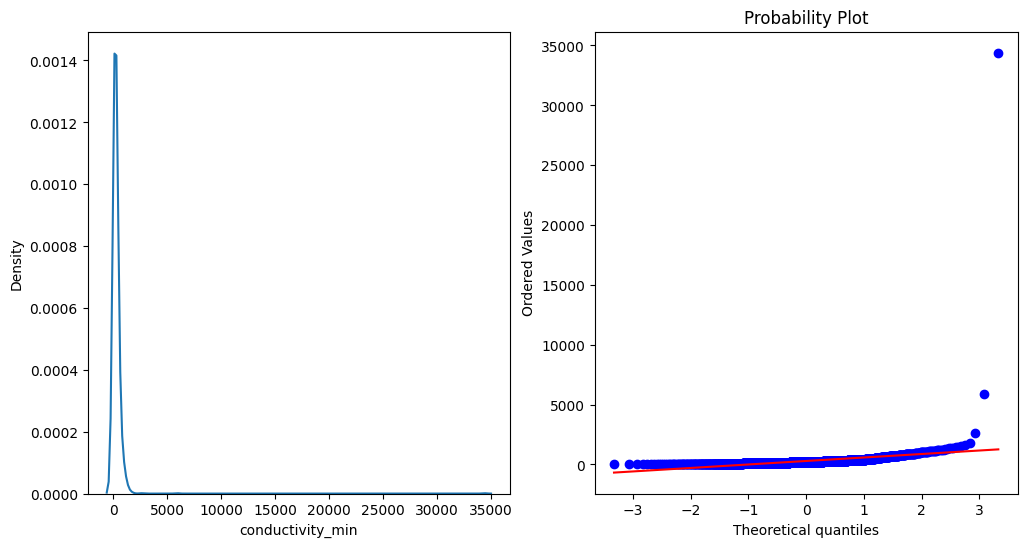

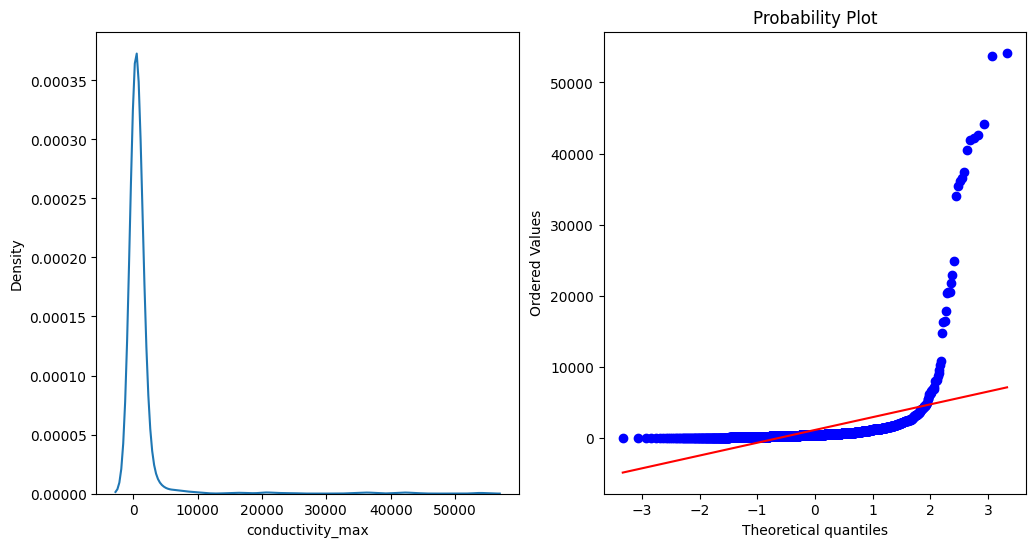

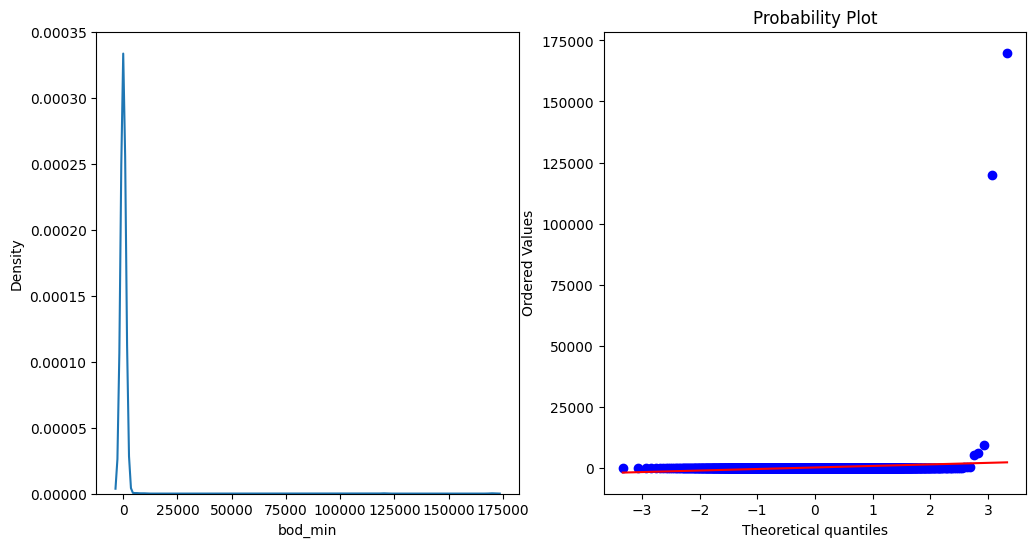

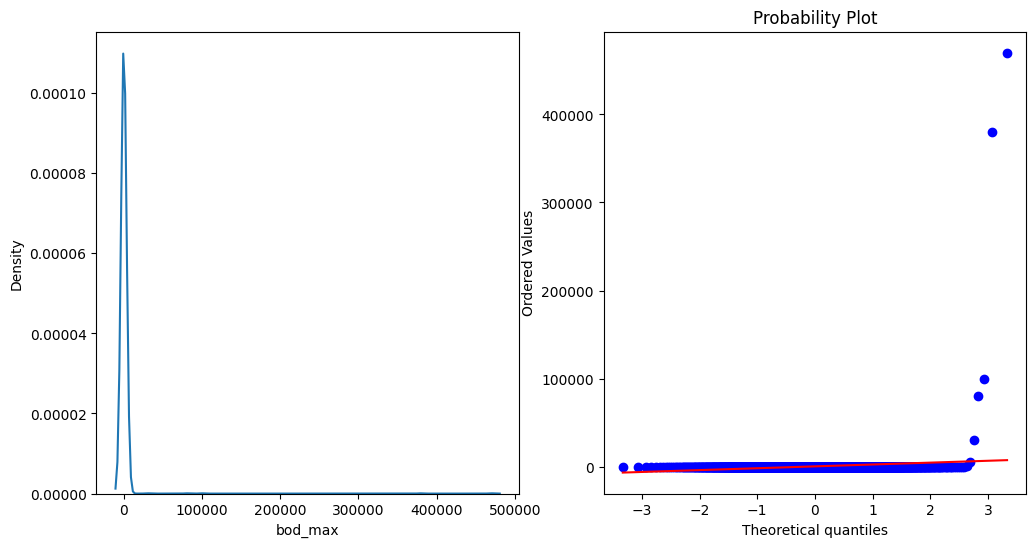

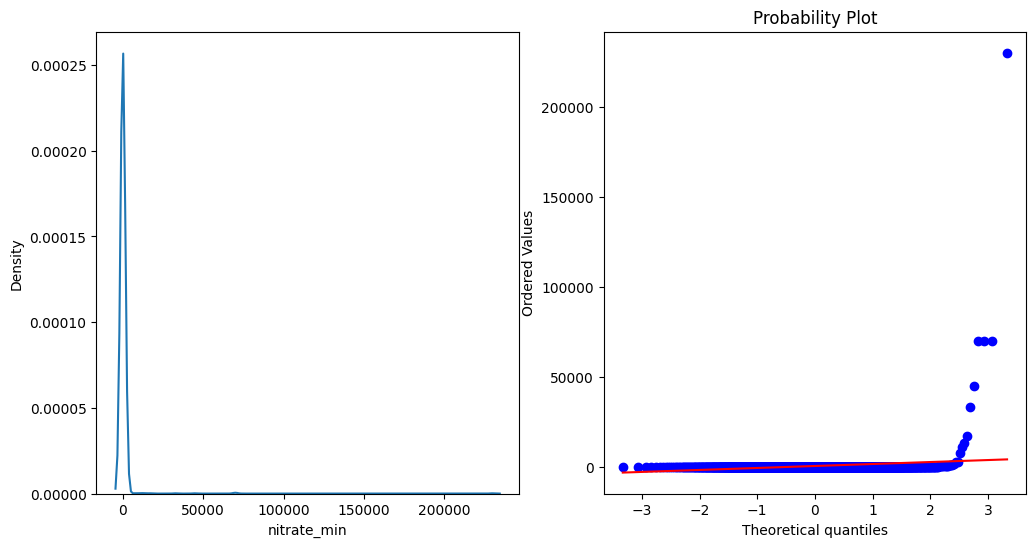

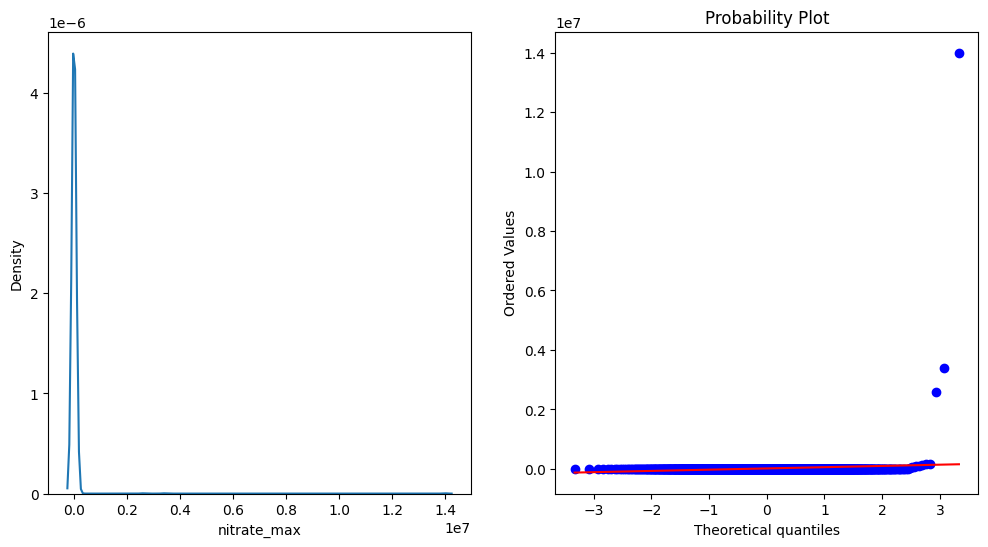

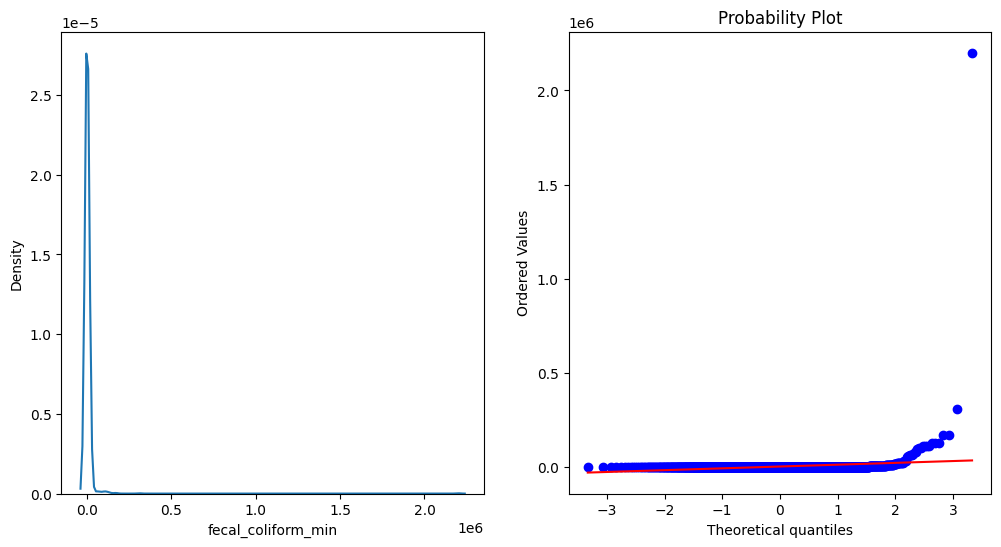

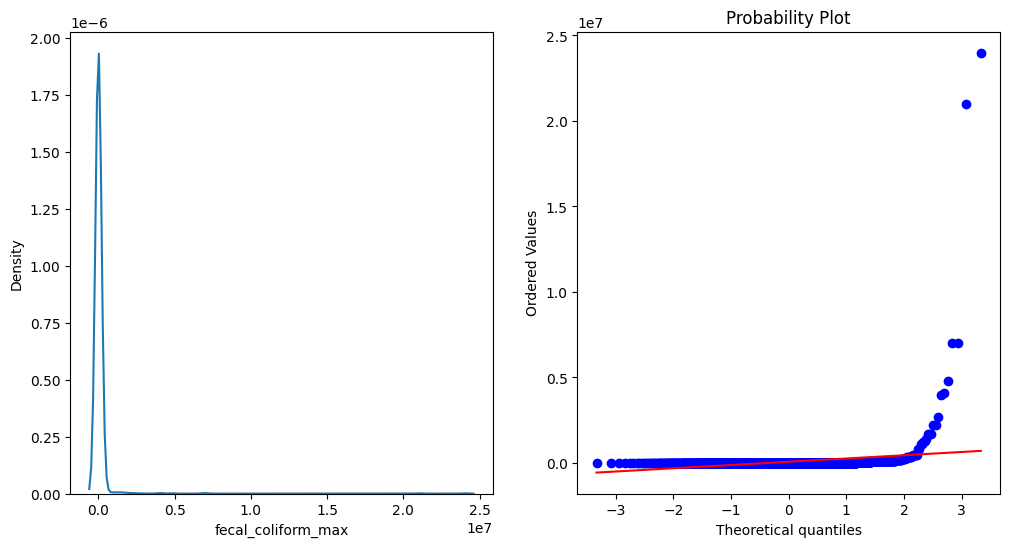

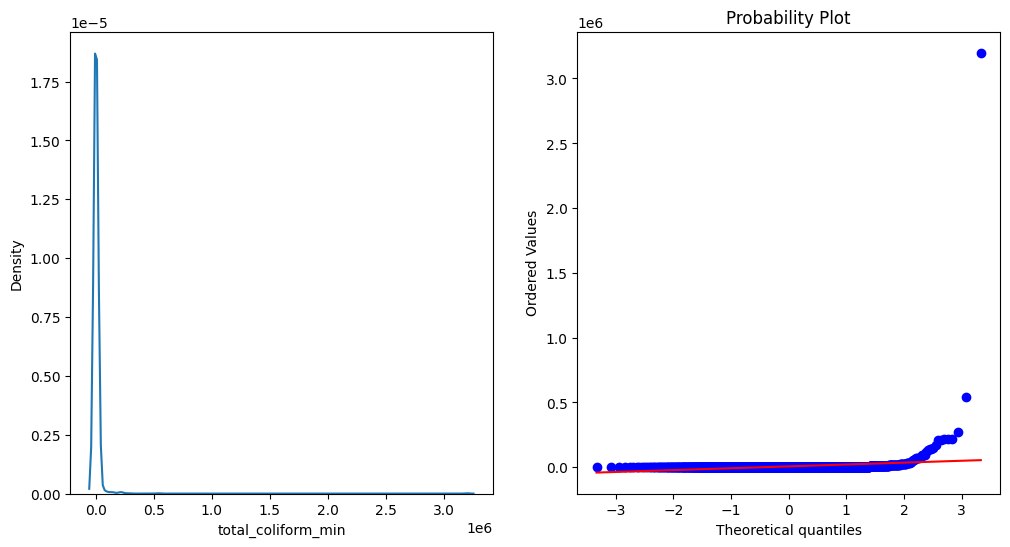

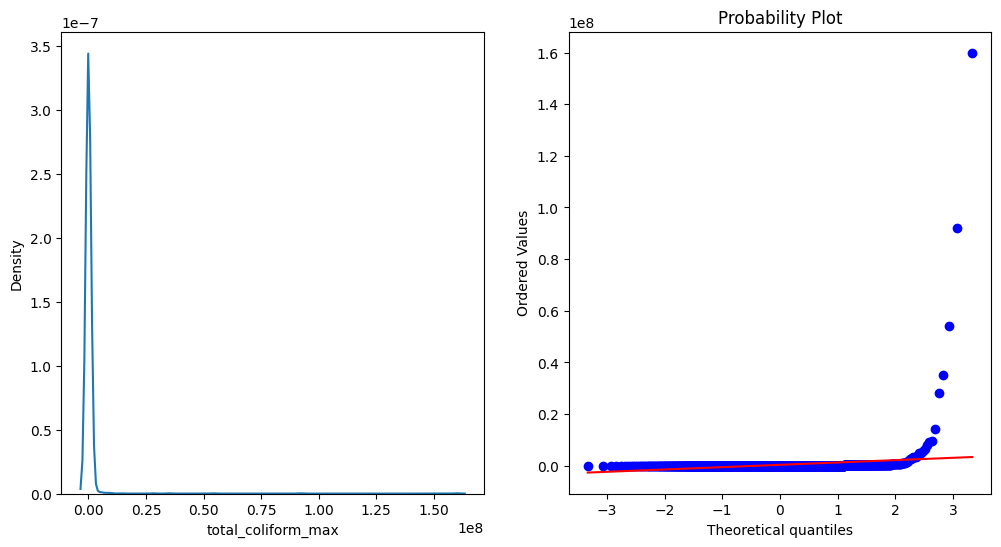

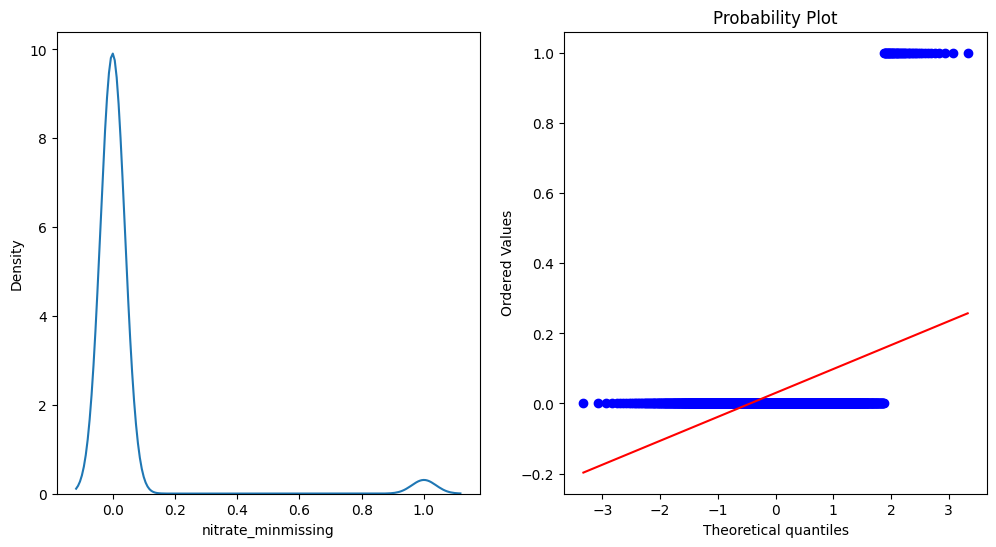

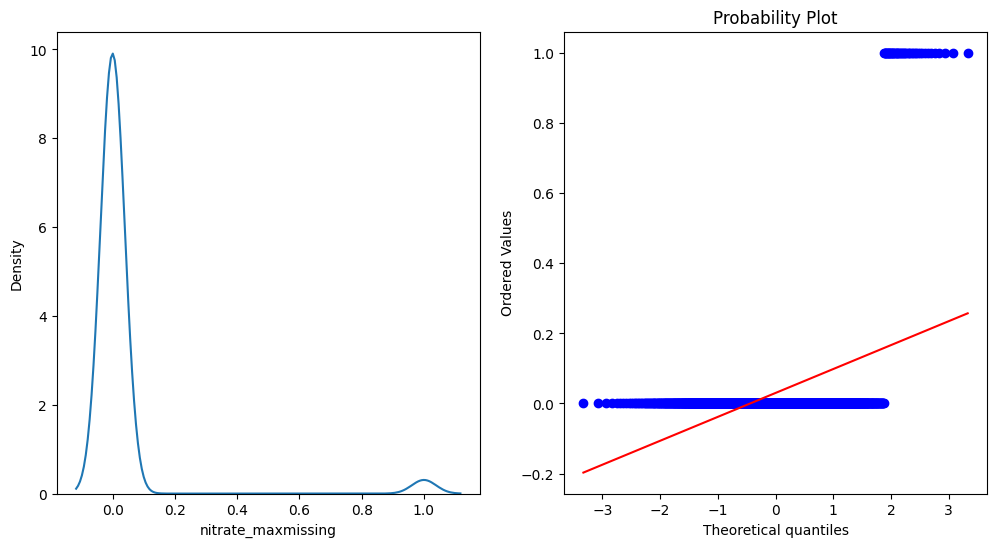

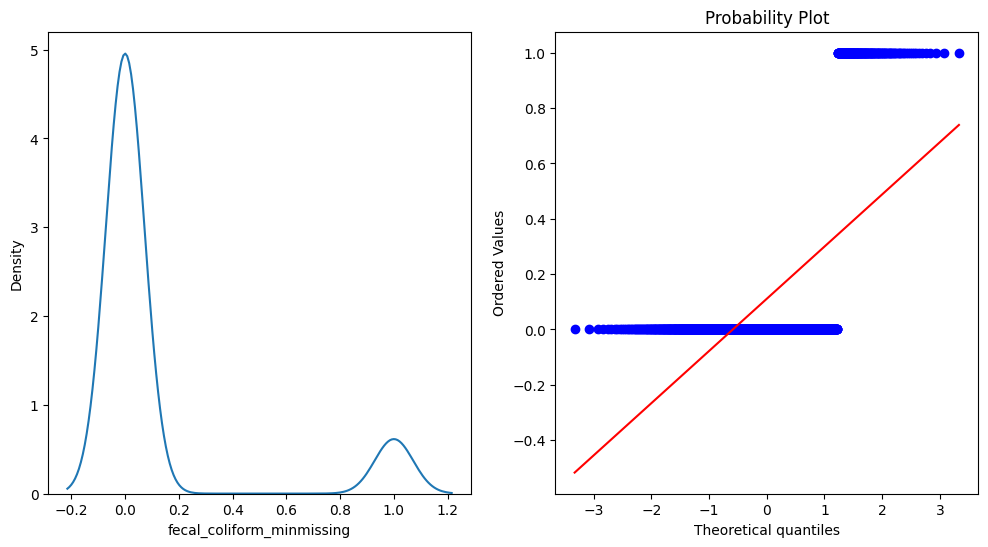

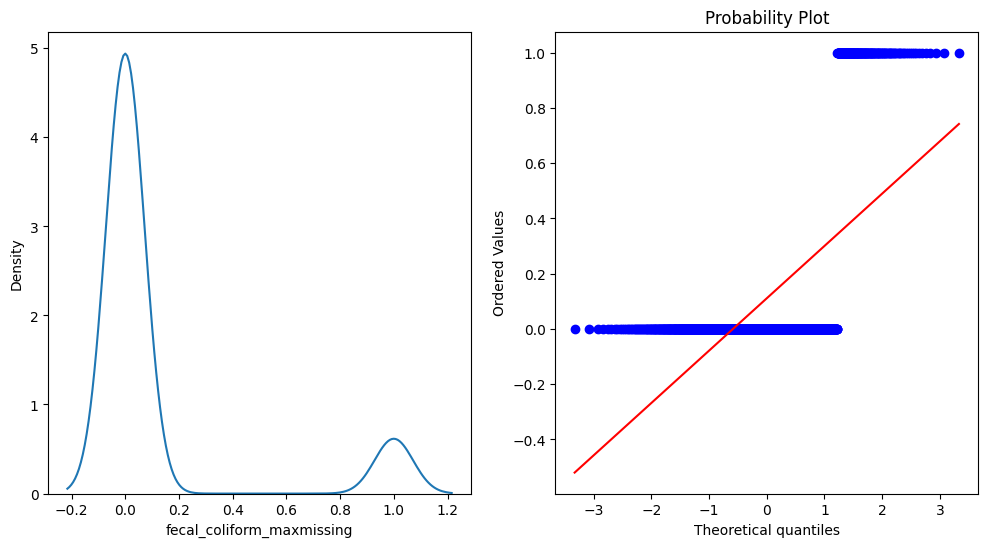

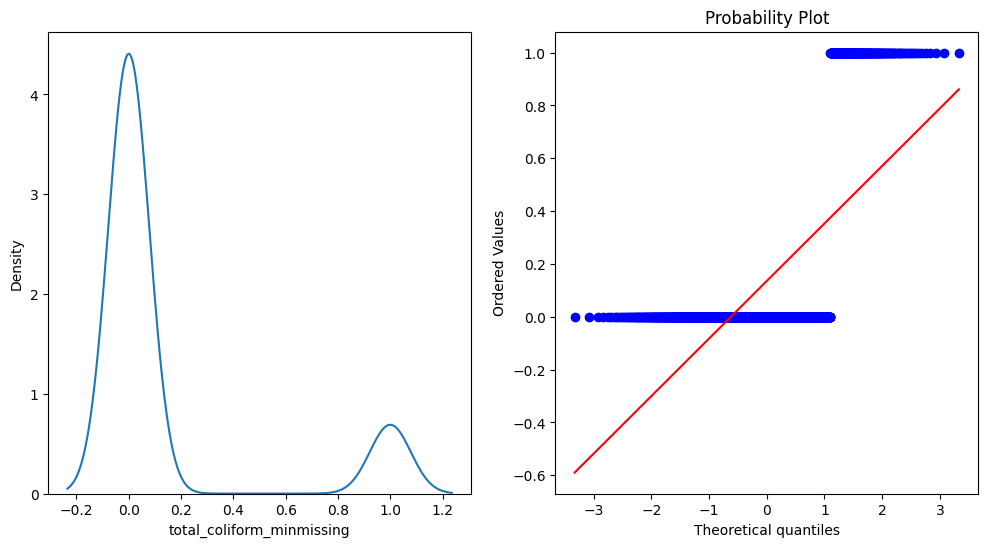

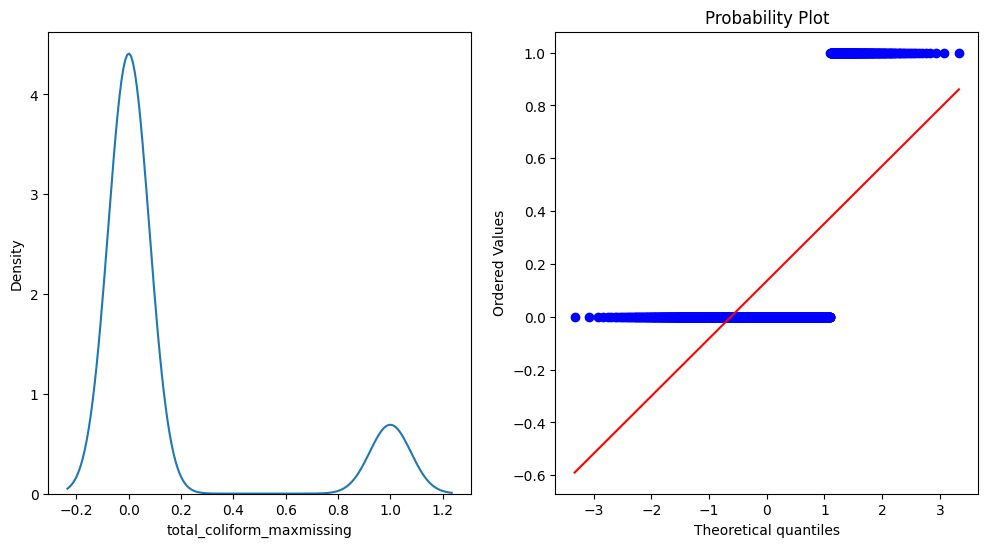

In [18]:
from scipy import stats as stats

for col in df.select_dtypes(np.number).columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    sns.kdeplot(df, x=col, ax=ax1)
    stats.probplot(df[col], dist='norm', plot=ax2)
    plt.show()

In [19]:
df[['temp_min', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min', 'conductivity_max', 'bod_min', 'bod_max','nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']] = df[['temp_min', 'do_min', 'do_max', 'ph_min', 'ph_max', 'conductivity_min', 'conductivity_max', 'bod_min', 'bod_max','nitrate_min', 'nitrate_max', 'fecal_coliform_min', 'fecal_coliform_max', 'total_coliform_min', 'total_coliform_max']].apply(np.log1p) # type: ignore

In [20]:
df[['temp_min', 'ph_min', 'ph_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max']] = df[['temp_min', 'ph_min', 'ph_max', 'bod_min', 'bod_max', 'nitrate_min', 'nitrate_max']].apply(np.log1p)

In [21]:
df.to_csv("./stations_cleaned.csv", index=False)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1597 entries, 1 to 1610
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   station_code               1597 non-null   int64  
 1   monitoring_location        1597 non-null   object 
 2   state_name                 1597 non-null   object 
 3   temp_min                   1597 non-null   float64
 4   temp_max                   1597 non-null   float64
 5   do_min                     1597 non-null   float64
 6   do_max                     1597 non-null   float64
 7   ph_min                     1597 non-null   float64
 8   ph_max                     1597 non-null   float64
 9   conductivity_min           1597 non-null   float64
 10  conductivity_max           1597 non-null   float64
 11  bod_min                    1597 non-null   float64
 12  bod_max                    1597 non-null   float64
 13  nitrate_min                1597 non-null   float64
 1